In [1]:
import time
import numpy as np
import onnxruntime as ort
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from scipy.spatial import distance
from sklearn.metrics import precision_score, recall_score

In [2]:
model_path = "./onnx_inference_model.onnx"
device_inference = "cpu"
input_size = (640, 480)
threshold = 0.5

In [3]:
def predict_image(image, ort_session):
    input_onnx = ort_session.get_inputs()[0].name
    outputs = ort_session.run(
        None,
        {input_onnx: image},
    )
    return outputs

def preprocessing_image(image_path):
    mean = np.array([0.5, 0.5, 0.5], dtype=np.float16)
    std = np.array([0.5, 0.5, 0.5], dtype=np.float16)
    
    image = np.array(Image.open(image_path).convert("RGB").resize(input_size))
    image_augmentation = A.Compose([
            A.Normalize(mean, std),
    ])
    image = image_augmentation(image=image)["image"]
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, 0)
    return image

def postprocessing_image(predict):
    predict = predict[0][0]
    predict = np.where(predict[1] > threshold, predict, 0)
    predict = np.ceil(predict)
    return predict

def get_all_result_confidence(predict, mask):
    all_result_confidence = []
    for prd in predict:
        iou = binary_mask_iou(prd, mask)
        all_result_confidence.append([1-iou, iou])
    return np.array(all_result_confidence)

def binary_mask_iou(mask1, mask2):
    mask1_area = np.count_nonzero(mask1)
    mask2_area = np.count_nonzero(mask2)
    intersection = np.count_nonzero(np.logical_and(mask1, mask2))
    iou = intersection / (mask1_area + mask2_area - intersection)
    return iou

In [4]:
ort_session = (ort.InferenceSession(model_path, providers=["CPUExecutionProvider" 
                                                           if device_inference == "cpu" 
                                                           else "CUDAExecutionProvider"])
)

In [5]:
image = "../../dataset_segmentation/Images/image_0.jpg"
mask = "../../dataset_segmentation/Masks/image_0.png"

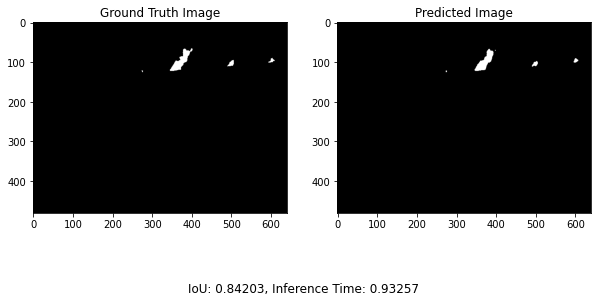

In [6]:
start_time = time.time()
predict = preprocessing_image(image)
predict = predict_image(predict, ort_session)
predict = postprocessing_image(predict)
end_time = time.time() - start_time
mask_image = np.array(Image.open(mask).resize(input_size))
all_result_confidence = get_all_result_confidence(predict, mask_image)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.supxlabel(f'IoU: {all_result_confidence[1][1]:.5f}, Inference Time: {end_time:.5f}')

ax[0].imshow(mask_image, cmap="gray")
ax[0].set_title("Ground Truth Image")

ax[1].imshow(predict[1], cmap="gray")
ax[1].set_title("Predicted Image")
plt.show()

In [7]:
with open("../annotations_test.txt", "r") as f:
    data_annotations_test = f.readlines()
    data_annotations_test = [data.replace('\n', '') for data in data_annotations_test]
    data_annotations_test = [data.replace('/content/datasets/Images/', '../../dataset_segmentation/Images/') for data in data_annotations_test]
    data_annotations_test = [data.replace('/content/datasets/Masks/', '../../dataset_segmentation/Masks/') for data in data_annotations_test]

In [8]:
predicted_iou = []
prediced_dice_loss = []
precision_labels = []
recall_labels = []

for data_test in tqdm(data_annotations_test):
    split_data_test = data_test.split(" ")
    image_path = split_data_test[0]
    mask_image_path = split_data_test[1]
    
    result_image = preprocessing_image(image_path)
    result_image = predict_image(result_image, ort_session)
    result_image = postprocessing_image(result_image)
    mask_image = np.array(Image.open(mask_image_path).resize(input_size))
    precision_labels.append(
        precision_score(mask_image.flatten(), result_image[1].flatten())
    )
    recall_labels.append(
        recall_score(mask_image.flatten(), result_image[1].flatten())
    )
    all_result_confidence = get_all_result_confidence(result_image, mask_image)
    predicted_iou.append(all_result_confidence[1][1])
    prediced_dice_loss.append(distance.dice(mask_image.flatten(), result_image[1].flatten()))
    
print("mIoU:", np.mean(predicted_iou))
print("Mean Average Precision:", np.mean(precision_labels))
print("Mean Average Recall:", np.mean(recall_labels))
print("Mean Average Dice Loss:", np.mean(prediced_dice_loss))

100%|██████████| 200/200 [04:44<00:00,  1.42s/it]

mIoU: 0.7902557220874855
Mean Average Precision: 0.8708536601985156
Mean Average Recall: 0.895678302059449
Mean Average Dice Loss: 0.11961976243980757
